In [34]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits import mplot3d

In [2]:
#Constants
alpha = 0.01
mu_0 = 1.25663706212*(10**(-6))
gamma = 1.76085963023*(10**11)
H = [0,0,1]

In [3]:
def eq1(x, y): 
    return ((x - y)/2) 

# A sample differential equation "dy/dx = -y" 
def eq2(x, y): 
    return (-y) 

# differential equation for precision term of LLGS" 
def eq3(t, M):
    return -(gamma*mu_0)/(1+alpha**2)*np.cross(M,H)
    
# # Finds value of y for a given x using step size h 
# # and initial value y0 at x0. 
def rungeKuttaNew(diff_eq, x_n, y_n, x, h): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * diff_eq(x_n, y) 
        k2 = h * diff_eq(x_n + 0.5*h, y + 0.5*k1*h) 
        k3 = h * diff_eq(x_n + 0.5*h, y + 0.5*k2*h) 
        k4 = h * diff_eq(x_n + h, y + k3*h) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y 

def rungeKutta(diff_eq, x_n, y_n, x, h): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * diff_eq(x_n, y) 
        k2 = h * diff_eq(x_n + 0.5*h, y + 0.5*k1) 
        k3 = h * diff_eq(x_n + 0.5*h, y + 0.5*k2) 
        k4 = h * diff_eq(x_n + h, y + k3) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y 

In [13]:
# # Test 1  
# x0 = 0
# y0 = 1
# x = 2
# h_list = [2, 1, 0.8, 0.5, 0.2, 0.1, 0.001, 10**(-3)]
# print("Using differential equation dy/dx = (x - y)/2")
# for h in h_list:
#     ans = rungeKuttaNew(eq1, x0, y0, x, h)
#     print('when h = {} the value of y at x is:{}'.format(str(h),ans))
#     print('accuracy = {}'.format(((1.605551275-ans)/1.605551275)*100))


In [14]:
# # Test 2  
# x0 = 0
# y0 = 1
# x = 5
# h_list = [2, 1, 0.8, 0.5, 0.2, 0.1 , 10**(-3)]
# print("Using differential equation new dy/dx = -y")
# for h in h_list:
#     ans = rungeKuttaNew(eq2, x0, y0, x, h)
#     print('when h = {} the value of y at x is:{}'.format(str(h),ans))
#     print('accuracy = {}'.format(((0.367879-ans)/0.367879)*100))

### Test with dy/dx=-y

In [6]:
# Test Debasis
x_axis = np.linspace(0,8,100)
y_anal = np.exp(-x_axis)
y_rk4 = []

for x in x_axis:
    y_rk4.append(rungeKuttaNew(eq2, 0, 1, x, 0.08))
    

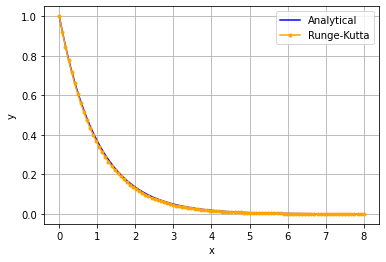

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(x_axis, y_anal, 'b', label='Analytical')
plt.plot(x_axis, y_rk4, 'orange', marker=".", label='Runge-Kutta')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right')
plt.grid()

plt.show()

### Test with precision term of LLGS

In [8]:
t_range = 5*10**(-4)
step_amount = 2001
t_axis = np.linspace(0,t_range,step_amount)

h = t_range/step_amount
m_0 = [0, 1/2, math.sqrt(1-(1/2)**2)]

# #analytical solution
# m_anal = []
# for t in t_axis:
#     m_anal_res = np.exp(-(gamma*mu_0)/(1+alpha**2)*t*H)
#     m_anal.append(m_anal_res)
#     print(m_anal_res)

In [9]:
# RK4 solution
m_rk4 = []
m_prev = m_0
t_prev = 0

for t in t_axis:
    new_m = rungeKutta(eq3, t_prev, m_prev, t, h)
    m_rk4.append(new_m)
    m_prev = new_m
    t_prev = t

In [10]:
# change all elements to list
for i in range(1,len(m_rk4)):
    m_rk4[i] = m_rk4[i].tolist()
    
mx = [item[0] for item in m_rk4]
my = [item[1] for item in m_rk4]
mz = [item[2] for item in m_rk4]

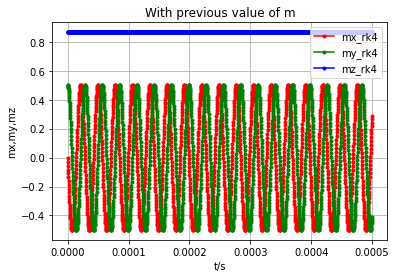

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plt.plot(t_axis, m_anal, label='Analytical')

plt.plot(t_axis, mx, '.r-', label='mx_rk4')
plt.plot(t_axis, my, '.g-', label='my_rk4')
plt.plot(t_axis, mz, '.b-', label='mz_rk4')

plt.title("With previous value of m")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()

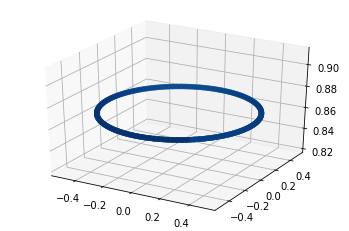

In [42]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.plot3D(mx, my, mz, 'gray')
ax.scatter3D(mx, my, mz, c=t_axis, cmap='Blues');

In [15]:
mxmy_anal = -(gamma*mu_0)/(1+alpha**2)*t_axis

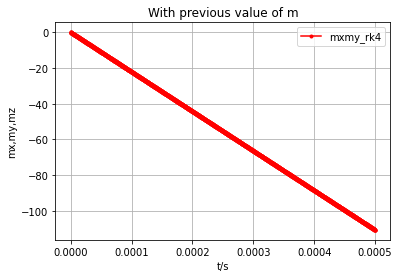

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plt.plot(t_axis, m_anal, label='Analytical')

plt.plot(t_axis, mxmy_anal, '.r-', label='mxmy_rk4')
# plt.plot(t_axis, my, '.g-', label='my_rk4')
# plt.plot(t_axis, mz, '.b-', label='mz_rk4')

plt.title("With previous value of m")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()

In [47]:
# ## failed attempt
# mx_anal = -(gamma*mu_0)/(1+alpha**2)*t_axis*my

# my_anal = (gamma*mu_0)/(1+alpha**2)*t_axis*mx


# # my_anal = []
# # for i in range(0,len(t_axis)):
# #     my_anal = -mx[i]*((1+alpha**2)/(gamma*mu_0))/t_axis[i]

In [69]:
mx_anal=[]
my_anal=[]
for i in range(0,len(t_axis)):
    s_y = 1/(-2*(gamma*mu_0)/(1+alpha**2) - 2*math.tan(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]))
    my_anal.append(0.5*math.cos(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]) + s_y*math.sin(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]))
    mx_anal.append(0.5*math.sin(-(gamma*mu_0)/(1+alpha**2)*H[2]*t_axis[i]))

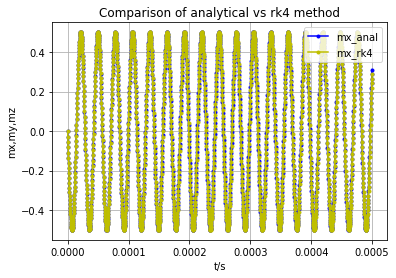

In [73]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plt.plot(t_axis, m_anal, label='Analytical')

plt.plot(t_axis, mx_anal, '.b-', label='mx_anal')
plt.plot(t_axis, mx, '.y-', label='mx_rk4')

plt.title("Comparison of analytical vs rk4 method")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()

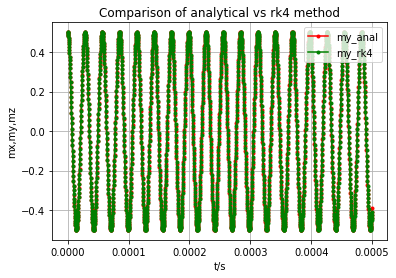

In [74]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plt.plot(t_axis, m_anal, label='Analytical')

plt.plot(t_axis, my_anal, '.r-', label='my_anal')
plt.plot(t_axis, my, '.g-', label='my_rk4')

plt.title("Comparison of analytical vs rk4 method")
plt.xlabel("t/s")
plt.ylabel("mx,my,mz")
plt.legend(loc='upper right')
plt.grid()

plt.show()